https://www.kaggle.com/code/soheiltehranipour/customer-chrun-imbalanced-data/input

In [1]:
pip install imbalanced-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: C:\Users\ngkho\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
%matplotlib inline

In [80]:
import pandas as pd
import numpy as np

#preprocessing
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

#chia du lieu train test
from sklearn.model_selection import train_test_split

#PipeLine
from sklearn.pipeline import Pipeline

#xu ly null value
from sklearn.impute import SimpleImputer

#SVM: Gồm SVC và SVR (2 bai toan classification và regression)
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#chuan hoa dang so 
from sklearn.preprocessing import StandardScaler

#thu vien report data
from ydata_profiling import ProfileReport

from sklearn.compose import ColumnTransformer
#model danh gia cho classification
from sklearn.metrics import classification_report

#Cach Chon nhanh sieu tham so cho mo hinh de toi uu 
from sklearn.model_selection import GridSearchCV

#Kiem tra overfitting
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

#UnderSampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

#OverSampling
from imblearn.over_sampling import RandomOverSampler

#SMOTE
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from imblearn.combine import SMOTETomek, SMOTEENN




In [4]:
# doc va hien thi du lieu
data = pd.read_csv('Telco-Customer-Churn.csv')
data.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,...,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,...,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [5]:
#result_describe = data.describe()
#result_info = data.info()

#statistic and visualize data
#chi co y nghia neu bo du lieu co dang so va categorical, neu chua text nhiu se ko y nghia
profile = ProfileReport(data, title="Churn Customer Report", explorative=True)
profile.to_file("Churn_report.html")

Summarize dataset:  82%|████████▏ | 23/28 [00:00<00:00, 44.47it/s, Calculate auto correlation]        C:\Users\ngkho\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\ydata_profiling\model\correlations.py:66: UserWarning: There was an attempt to calculate the auto correlation, but this failed.
To hide this warning, disable the calculation
(using `df.profile_report(correlations={"auto": {"calculate": False}})`
If this is problematic for your use case, please report this as an issue:
https://github.com/ydataai/ydata-profiling/issues
(include the error message: 'could not convert string to float: 'No'')
  warnings.warn(
Export report to file: 100%|██████████| 1/1 [00:00<00:00, 250.53it/s]


Churn
No     5174
Yes    1869
Name: count, dtype: int64


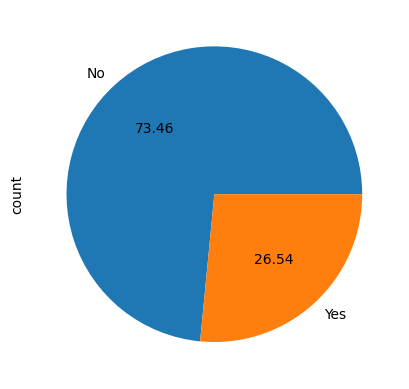

In [6]:
#Prove that data imbalanced < 10 (not highly imbalanced > 10)
churn = data['Churn']
print(churn.value_counts())

churn = churn.value_counts().plot.pie(autopct = '%.2f')


B0: Overall analyze - understand dataset
Hiểu dữ liệu (phân chia loại dữ liệu, kiểm tra null, visualize,...)
B1: Data Split
chia du lieu chieu doc, chia du lieu dang ngang
b2: Data preprocessing
chuan hoa du lieu

*Lưu ý:
Lý do phải split trước khi preprocessing vì trong preprocessing sẽ tương tác trên tập test, nên chia trước train test để tránh bị data leakage => ảnh hưởng đến kết quả

Chuan hoa du lieu 
- tuy duy lieu dang gi de xu ly
numerical features: su dung MinMaxScaler, StandardScaler

+ StandarScaler
fit - đo kì vọng và độ lệch chuẩn từng cột trong x_train
transform - Tu 2 thong so tren de tinh ra ket qua du lieu moi
fit_transform - lam ca 2

+MinMaxScaler
fit, transform - do min max cua tung cot mot

Luu y: Khong dc dung fit voi bo test => data leakage (ro ri du lieu) => Khong con dung nua

Meọ chọn mô hình tuyến tính hay phi tuyến tính: 
- Dựa vào hệ số tương quan (correlations) + hệ số tương quan giữa các feature và cột target ko lớn hơn > 0.7 hay < -0.7 (thấp) => Mô hình phi tuyến (SVM (add them chiều mới vào), )
                                        + Chỉ cần có 1 Hệ số tương quan cao => Mô hình tuyến tính (là mô hình bậc 1(1 chiều))

In [7]:
#Identify Categorical Variables with unique values 
# Lam buoc nay de xac dinh loai cua tung thuoc tinh va xac dinh feature nao quan trong trong viec du doan phan loai kha nang roi bo khach hang
def unique_value(data):
       for column in data:
            if data[column].dtypes=='object':
                print(f'{column}: {data[column].unique()}') 
                
unique_value(data) 
#this step show a data['TotalCharges'] not really a float

#numerical(so) : Int, Float
#Categorical(phan loai): nominal (dinh danh), ordinal (thu bac), boolean

#customerID: nominal (dinh danh) (not important)
#gender: boolean
#Partner: boolean
#Dependents: boolean
#PhoneService: boolean
#MultipleLines: ordinal 
#InternetService: ordinal
#OnlineSecurity: ordinal
#OnlineBackup: ordinal
#DeviceProtection: ordinal
#TechSupport: ordinal
#StreamingTV: ordinal
#StreamingMovies: ordinal
#Contract: ordinal
#PaperlessBilling: boolean
#PaymentMethod: nominal
#TotalCharges: ordinal (should be float)
#Churn: boolean


customerID: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']
Churn: ['No' 'Yes']


In [8]:
target = "Churn"
# 0 -> hang, 1 -> cot
id = "customerID" 

x = data.drop(target, axis=1) # bien doc lap
x = data.drop(id, axis=1) # bien doc lap
y = data[target]              # bien phu thuoc

print(x)
print(y)

      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     Female              0     Yes         No       1           No   
1       Male              0      No         No      34          Yes   
2       Male              0      No         No       2          Yes   
3       Male              0      No         No      45           No   
4     Female              0      No         No       2          Yes   
...      ...            ...     ...        ...     ...          ...   
7038    Male              0     Yes        Yes      24          Yes   
7039  Female              0     Yes        Yes      72          Yes   
7040  Female              0     Yes        Yes      11           No   
7041    Male              1     Yes         No       4          Yes   
7042    Male              0      No         No      66          Yes   

         MultipleLines InternetService OnlineSecurity OnlineBackup  \
0     No phone service             DSL             No          Yes   
1      

In [9]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [10]:
# 20% test, 80% train, 20 val (lay val trong train)  su dung stratify de chia cho deu từng class một giua bộ train va bộ test trong cột target => ty le 80/20 = 4:1 neu tong so target la 5 se dep nhat ko se chia gan dung. Cach nay ap dun cho tung class
# Neu ko dung stratify se co kha nang bo test se chia toàn bộ dữ liệu thiểu số vào training cả vì là random
# bo validation la bo du lieu kiem tra xem trong qua trinh huan luyen co dang hoc dung huong hay ko
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, stratify=y, random_state=10)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, stratify=y_train, random_state=10)

print("Training data shape x:", x_train.shape)
print("Training labels shape y:", y_train.shape)
print("Validation data shape x:", x_val.shape)
print("Validation labels shape y:", y_val.shape)
print("Test data shape x:", x_test.shape)
print("Test labels shape y:", y_test.shape)

#x_train và y_train: Tập huấn luyện (80% của dữ liệu ban đầu).
#x_val và y_val: Tập xác thực (20% của dữ liệu ban đầu, 25% của tập huấn luyện).
#x_test và y_test: Tập kiểm tra (20% của dữ liệu ban đầu)

Training data shape x: (4225, 20)
Training labels shape y: (4225,)
Validation data shape x: (1409, 20)
Validation labels shape y: (1409,)
Test data shape x: (1409, 20)
Test labels shape y: (1409,)


Churn
No     3104
Yes    1121
Name: count, dtype: int64
Churn
No     1035
Yes     374
Name: count, dtype: int64


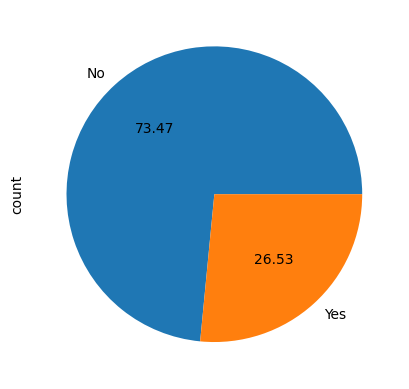

In [11]:
print(y_train.value_counts())
print(y_test.value_counts())

churn = y_train.value_counts().plot.pie(autopct = '%.2f')

Xy ly cot TotalCharges

In [12]:
print(x_train['TotalCharges'].dtype)


object


In [13]:
# 1. Loại bỏ khoảng trắng ở đầu và cuối chuỗi
x_train['TotalCharges'] = x_train['TotalCharges'].str.strip()

# 2. Thay thế chuỗi rỗng và các giá trị đặc biệt bằng NaN
x_train['TotalCharges'] = x_train['TotalCharges'].replace([' ', '', 'NaN', 'null'], np.nan)

# 3. Chuyển đổi thành số, chuyển các lỗi thành NaN
x_train['TotalCharges'] = pd.to_numeric(x_train['TotalCharges'], errors='coerce')



In [14]:
# 2. Thay thế chuỗi rỗng và các giá trị đặc biệt bằng NaN
x_train['MonthlyCharges'] = x_train['MonthlyCharges'].replace([' ', '', 'NaN', 'null'], np.nan)

# 3. Chuyển đổi thành số, chuyển các lỗi thành NaN
x_train['MonthlyCharges'] = pd.to_numeric(x_train['MonthlyCharges'], errors='coerce')

In [15]:
# 2. Thay thế chuỗi rỗng và các giá trị đặc biệt bằng NaN
x_train['tenure'] = x_train['tenure'].replace([' ', '', 'NaN', 'null'], np.nan)

# 3. Chuyển đổi thành số, chuyển các lỗi thành NaN
x_train['tenure'] = pd.to_numeric(x_train['tenure'], errors='coerce')

In [16]:
#kiem tra co du lieu bị khuyết ko (null) hay not a number -> khuyet it (drop), khuyet nhieu (dien vao) (mean. median, most frequent) (sklearn.SimpleImputer)
# Print the count of NaN values
print(f"Number of NaN values: {x_train['TotalCharges'].isna().sum()}")


# Get rows where 'TotalCharges' is NaN
na_rows = x_train[x_train['TotalCharges'].isna()]

# Add 2 to the row indices and print
na_rows.index = na_rows.index
print("\nRows with NaN values in 'TotalCharges'):")
print(na_rows)

Number of NaN values: 6

Rows with NaN values in 'TotalCharges'):
      gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
6754    Male              0      No        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
488   Female              0     Yes        Yes       0           No   
936   Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
6754               Yes             DSL                  Yes   
4380                No              No  No internet service   
3826               Yes              No  No internet service   
488   No phone service             DSL                  Yes   
936                 No             DSL                  Yes   
5218                No              No  No internet servic

In [17]:
print(x_train['TotalCharges'].dtype)

float64


In [18]:
#PineLine: Thay vi goi nhieu buoc rieng le, goi 1 lan
# tom tat: xu ly xong object -> float / " " -> NAN -> median -> numeric 
# xong x_train[["MonthlyCharges","TotalCharges"
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
    ])

result = num_transformer.fit_transform(x_train[["tenure","MonthlyCharges","TotalCharges"]])

for i, j in zip(x_train[["tenure","MonthlyCharges","TotalCharges"]].values, result):
    print("before {} . After {}".format(i,j))


before [ 12.   19.8 229.6] . After [-0.84544552 -1.49654088 -0.91277922]
before [  51.     96.4  4911.05] . After [0.74584898 1.03835544 1.1473158 ]
before [  2.   69.  147.8] . After [-1.25346975  0.13161707 -0.94877571]
before [  34.     96.35 3190.25] . After [0.05220779 1.03670081 0.39006932]
before [  8.    49.4  408.25] . After [-1.00865521 -0.5169987  -0.83416341]
before [ 1.  44.9 44.9] . After [-1.29427217 -0.66591558 -0.99405736]
before [  2.    89.55 185.55] . After [-1.25346975  0.81167085 -0.93216363]
before [  20.     94.55 1899.65] . After [-0.51902614  0.97713406 -0.17786553]
before [  63.     80.3  4896.35] . After [1.23547805 0.50556392 1.14084699]
before [  5.   85.4 401.1] . After [-1.13106248  0.67433639 -0.8373098 ]
before [  69.     19.1  1268.85] . After [ 1.48029259 -1.51970573 -0.45545216]
before [  7.    69.85 515.45] . After [-1.04945763  0.15974582 -0.78698952]
before [  5.    69.95 330.15] . After [-1.13106248  0.16305508 -0.8685317 ]
before [  32.    75.5

In [19]:
# Xu ly nominal feature : 3 cach - OneHot, Hash-embeded, word-embeded

nom_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(sparse_output=False)) 
    ])

# Giai thich : A -> 1,0,0,0 -> (0,0) 1.0 / B -> 0,0,1,0,0 -> (0,2) 1.0 

result = nom_transformer.fit_transform(x_train[["PaymentMethod"]])

for i, j in zip(x_train[["PaymentMethod"]].values, result):
    print("before {} . After {}".format(i,j))
    
# y nghia 


before ['Bank transfer (automatic)'] . After [1. 0. 0. 0.]
before ['Credit card (automatic)'] . After [0. 1. 0. 0.]
before ['Credit card (automatic)'] . After [0. 1. 0. 0.]
before ['Electronic check'] . After [0. 0. 1. 0.]
before ['Electronic check'] . After [0. 0. 1. 0.]
before ['Mailed check'] . After [0. 0. 0. 1.]
before ['Bank transfer (automatic)'] . After [1. 0. 0. 0.]
before ['Electronic check'] . After [0. 0. 1. 0.]
before ['Credit card (automatic)'] . After [0. 1. 0. 0.]
before ['Electronic check'] . After [0. 0. 1. 0.]
before ['Mailed check'] . After [0. 0. 0. 1.]
before ['Bank transfer (automatic)'] . After [1. 0. 0. 0.]
before ['Electronic check'] . After [0. 0. 1. 0.]
before ['Bank transfer (automatic)'] . After [1. 0. 0. 0.]
before ['Electronic check'] . After [0. 0. 1. 0.]
before ['Mailed check'] . After [0. 0. 0. 1.]
before ['Mailed check'] . After [0. 0. 0. 1.]
before ['Electronic check'] . After [0. 0. 1. 0.]
before ['Electronic check'] . After [0. 0. 1. 0.]
before ['

In [20]:

# Xu Ly Boolean
# Nen su dung nom_transformer hay ord_transformer ? -> Nao cung dung, dung ord_transformer tiet kiem bo nho hon (tao ra 1 cot)
gender_values = ['Female', 'Male']
Partner_values =  ['No', 'Yes']
Dependents_values =  ['No', 'Yes']
PhoneService_values = ['No', 'Yes']
PaperlessBilling_values = ['No', 'Yes']


MultipleLines_values =  ['No phone service', 'No', 'Yes']
InternetService_values = ['No', 'DSL', 'Fiber optic']
OnlineSecurity_values = ['No internet service', 'No', 'Yes']
OnlineBackup_values =  ['No internet service','Yes', 'No']
DeviceProtection_values = ['No internet service', 'No', 'Yes']
TechSupport_values = ['No internet service', 'No', 'Yes']
StreamingTV_values =  ['No internet service', 'No', 'Yes']
StreamingMovies_values =  ['No internet service', 'No', 'Yes']
Contract_values = ['Month-to-month', 'One year', 'Two year']

ord_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OrdinalEncoder(categories=[gender_values, Partner_values, Dependents_values, PhoneService_values, MultipleLines_values, InternetService_values, OnlineSecurity_values, OnlineBackup_values,DeviceProtection_values, TechSupport_values,StreamingTV_values,StreamingMovies_values,Contract_values, PaperlessBilling_values]))
    ])
result = ord_transformer.fit_transform(x_train[["gender", "Partner", "Dependents", "PhoneService","MultipleLines" , "InternetService", "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract", "PaperlessBilling"]])

for i, j in zip(x_train[["gender", "Partner", "Dependents", "PhoneService", "PaperlessBilling"]].values, result):
    print("before {} . After {}".format(i,j))



before ['Female' 'Yes' 'Yes' 'Yes' 'No'] . After [0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
before ['Male' 'Yes' 'No' 'Yes' 'Yes'] . After [1. 1. 0. 1. 2. 2. 2. 1. 1. 1. 1. 2. 1. 1.]
before ['Female' 'Yes' 'No' 'Yes' 'No'] . After [0. 1. 0. 1. 1. 1. 1. 2. 2. 1. 2. 2. 0. 0.]
before ['Female' 'No' 'No' 'Yes' 'Yes'] . After [0. 0. 0. 1. 2. 2. 1. 1. 1. 2. 2. 1. 0. 1.]
before ['Female' 'No' 'No' 'Yes' 'No'] . After [0. 0. 0. 1. 1. 1. 1. 2. 1. 2. 1. 1. 0. 0.]
before ['Male' 'No' 'No' 'Yes' 'Yes'] . After [1. 0. 0. 1. 1. 1. 1. 2. 1. 1. 1. 1. 0. 1.]
before ['Male' 'Yes' 'Yes' 'Yes' 'Yes'] . After [1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 2. 2. 0. 1.]
before ['Male' 'Yes' 'No' 'Yes' 'Yes'] . After [1. 1. 0. 1. 2. 2. 1. 2. 1. 1. 2. 2. 0. 1.]
before ['Male' 'Yes' 'Yes' 'Yes' 'Yes'] . After [1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 0. 1.]
before ['Male' 'Yes' 'No' 'Yes' 'Yes'] . After [1. 1. 0. 1. 2. 2. 1. 1. 1. 2. 1. 1. 0. 1.]
before ['Male' 'No' 'No' 'Yes' 'Yes'] . After [1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 2.

In [21]:
preprocessor = ColumnTransformer(transformers= [
    ("num_feature", num_transformer, ["tenure","MonthlyCharges","TotalCharges"]),
    ("ord_feature", ord_transformer, ["gender", "Partner", "Dependents", "PhoneService","MultipleLines" , "InternetService", "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract", "PaperlessBilling"]),
    ("nom_feature", nom_transformer, ["SeniorCitizen","PaymentMethod"]),                             
])

reg = Pipeline(steps=[
    ("preporcessor", preprocessor),
    ("model", SVC())
])



In [22]:
reg.fit(x_train, y_train)

Pipeline(steps=[('preporcessor',
                 ColumnTransformer(transformers=[('num_feature',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('ord_feature',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(categories=[['Female',
                                                                                               'Male...
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling']),
                                                 ('nom_feature',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['SeniorCitizen',
                                                   'PaymentMethod'])])),
                ('model', SVC())])

In [23]:
# 1. Loại bỏ khoảng trắng ở đầu và cuối chuỗi
x_test['TotalCharges'] = x_test['TotalCharges'].str.strip()

# 2. Thay thế chuỗi rỗng và các giá trị đặc biệt bằng NaN
x_test['TotalCharges'] = x_test['TotalCharges'].replace([' ', '', 'NaN', 'null'], np.nan)

# 3. Chuyển đổi thành số, chuyển các lỗi thành NaN
x_test['TotalCharges'] = pd.to_numeric(x_test['TotalCharges'], errors='coerce')

y_predict = reg.predict(x_test)

for i, j in zip(y_predict, y_test):
    print("Predicted Value: {} . Actual Value: {}".format(i,j))

Predicted Value: No . Actual Value: Yes
Predicted Value: No . Actual Value: No
Predicted Value: No . Actual Value: Yes
Predicted Value: No . Actual Value: Yes
Predicted Value: No . Actual Value: No
Predicted Value: No . Actual Value: No
Predicted Value: No . Actual Value: Yes
Predicted Value: No . Actual Value: Yes
Predicted Value: No . Actual Value: No
Predicted Value: No . Actual Value: No
Predicted Value: No . Actual Value: No
Predicted Value: Yes . Actual Value: Yes
Predicted Value: Yes . Actual Value: Yes
Predicted Value: Yes . Actual Value: Yes
Predicted Value: Yes . Actual Value: Yes
Predicted Value: Yes . Actual Value: Yes
Predicted Value: No . Actual Value: Yes
Predicted Value: No . Actual Value: Yes
Predicted Value: No . Actual Value: No
Predicted Value: Yes . Actual Value: No
Predicted Value: No . Actual Value: No
Predicted Value: No . Actual Value: No
Predicted Value: No . Actual Value: No
Predicted Value: No . Actual Value: No
Predicted Value: No . Actual Value: No
Predict

In [24]:
print(classification_report(y_test, y_predict))

# De danh gia hay so sanh 1 mo hinh classification can biet minh can precision hay recall 
#SVC 
#                 precision   recall  f1-score   support
 
#          No       0.82      0.91      0.86      1035
#         Yes       0.65      0.44      0.53       374

#   accuracy                           0.79      1409
#   macro avg       0.73      0.68      0.69      1409
#weighted avg       0.77      0.79      0.77      1409




              precision    recall  f1-score   support

          No       0.82      0.91      0.86      1035
         Yes       0.65      0.44      0.53       374

    accuracy                           0.79      1409
   macro avg       0.73      0.68      0.69      1409
weighted avg       0.77      0.79      0.77      1409



Training Accuracy: 0.8127810650887574
Test Accuracy: 0.7877927608232789


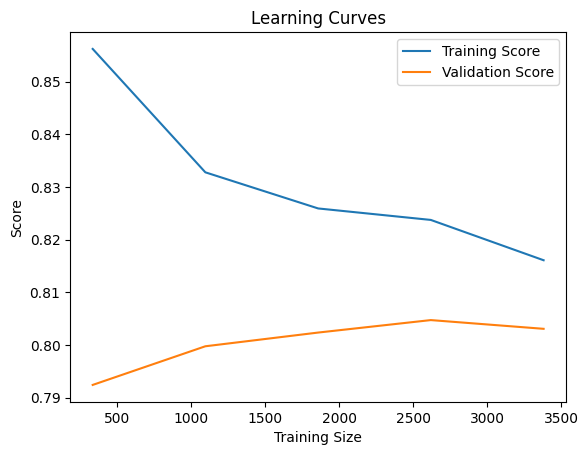

In [25]:
#Kiem tra Overfitting:
y_train_pred = reg.predict(x_train)
y_test_pred = reg.predict(x_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")



train_sizes, train_scores, test_scores = learning_curve(reg, x_train, y_train, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Training Score')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Validation Score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curves')
plt.legend()
plt.show()


In [26]:
preprocessor = ColumnTransformer(transformers= [
    ("num_feature", num_transformer, ["tenure","MonthlyCharges","TotalCharges"]),
    ("ord_feature", ord_transformer, ["gender", "Partner", "Dependents", "PhoneService","MultipleLines" , "InternetService", "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract", "PaperlessBilling"]),
    ("nom_feature", nom_transformer, ["SeniorCitizen","PaymentMethod"]),                             
])

reg = Pipeline(steps=[
    ("preporcessor", preprocessor),
    ("model", LogisticRegression())
])

reg.fit(x_train, y_train)
y_predict = reg.predict(x_test)
print(classification_report(y_test, y_predict))


              precision    recall  f1-score   support

          No       0.84      0.88      0.86      1035
         Yes       0.61      0.53      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



In [27]:
#LogisticRegression
#                 precision  recall   f1-score   support

#          No       0.84      0.88      0.86      1035
#         Yes       0.61      0.53      0.57       374

#    accuracy                           0.79      1409
#   macro avg       0.73      0.70      0.71      1409
#weighted avg       0.78      0.79      0.78      1409

In [28]:
params = {
    "n_estimators" : [100,200,300],
    "criterion" : ["gini", "entropy"],
    "class_weight" : [None, "balanced"]
}
preprocessor = ColumnTransformer(transformers= [
    ("num_feature", num_transformer, ["tenure","MonthlyCharges","TotalCharges"]),
    ("ord_feature", ord_transformer, ["gender", "Partner", "Dependents", "PhoneService","MultipleLines" , "InternetService", "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract", "PaperlessBilling"]),
    ("nom_feature", nom_transformer, ["SeniorCitizen","PaymentMethod"]),                             
])

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=100), param_grid=params, cv=4 , verbose=2)

reg = Pipeline(steps=[
    ("preporcessor", preprocessor),
    # tham so cua mo hinh và bộ này gọi là siêu tham số do dev chỉ ra để tối ưu mô hình
    ("model", grid_search)
])

reg.fit(x_train, y_train)
print(grid_search.best_estimator_)
print(grid_search.best_score_)  #score dua tren loss trung binh cua cross validation
print(grid_search.best_params_)

y_predict = reg.predict(x_test)
print(classification_report(y_test, y_predict))


Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] END class_weight=None, criterion=gini, n_estimators=100; total time=   0.3s
[CV] END class_weight=None, criterion=gini, n_estimators=100; total time=   0.3s
[CV] END class_weight=None, criterion=gini, n_estimators=100; total time=   0.3s
[CV] END class_weight=None, criterion=gini, n_estimators=100; total time=   0.2s
[CV] END class_weight=None, criterion=gini, n_estimators=200; total time=   0.7s
[CV] END class_weight=None, criterion=gini, n_estimators=200; total time=   0.6s
[CV] END class_weight=None, criterion=gini, n_estimators=200; total time=   0.6s
[CV] END class_weight=None, criterion=gini, n_estimators=200; total time=   0.6s
[CV] END class_weight=None, criterion=gini, n_estimators=300; total time=   0.9s
[CV] END class_weight=None, criterion=gini, n_estimators=300; total time=   1.0s
[CV] END class_weight=None, criterion=gini, n_estimators=300; total time=   0.9s
[CV] END class_weight=None, criterion=gini, n_es

Handle Imbalance Data

Naive UnderSampling

Churn
No     1121
Yes    1121
Name: count, dtype: int64


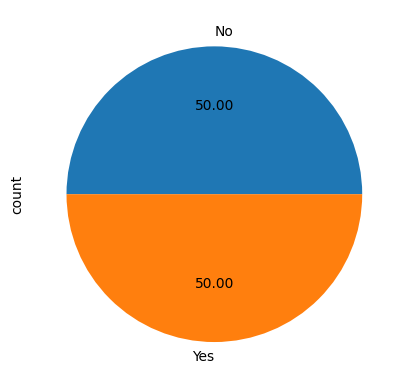

In [29]:
# Apply undersampling with RandomForestClassifer
undersample = RandomUnderSampler(random_state=42)
x_train_res, y_train_res = undersample.fit_resample(x_train, y_train)

resample_plot = y_train_res.value_counts().plot.pie(autopct ='%.2f')
print(y_train_res.value_counts())

In [30]:
undersample = RandomUnderSampler(random_state=42)
x_train_res, y_train_res = undersample.fit_resample(x_train, y_train)

params = {
    "n_estimators" : [100,200,300],
    "criterion" : ["gini", "entropy"],
    "class_weight" : [None, "balanced"]
}

preprocessor = ColumnTransformer(transformers= [
    ("num_feature", num_transformer, ["tenure","MonthlyCharges","TotalCharges"]),
    ("ord_feature", ord_transformer, ["gender", "Partner", "Dependents", "PhoneService","MultipleLines" , "InternetService", "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract", "PaperlessBilling"]),
    ("nom_feature", nom_transformer, ["SeniorCitizen","PaymentMethod"]),                             
])

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=100), param_grid=params, cv=4 , verbose=2)

reg = ImbPipeline(steps=[
    ("preporcessor", preprocessor),
    # tham so cua mo hinh và bộ này gọi là siêu tham số do dev chỉ ra để tối ưu mô hình
    ("model", grid_search)
])

reg.fit(x_train_res, y_train_res)
print(grid_search.best_estimator_)
print(grid_search.best_score_)  #score dua tren loss trung binh cua cross validation
print(grid_search.best_params_)

y_predict = reg.predict(x_test)
print(classification_report(y_test, y_predict))



Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] END class_weight=None, criterion=gini, n_estimators=100; total time=   0.2s
[CV] END class_weight=None, criterion=gini, n_estimators=100; total time=   0.1s
[CV] END class_weight=None, criterion=gini, n_estimators=100; total time=   0.2s
[CV] END class_weight=None, criterion=gini, n_estimators=100; total time=   0.2s
[CV] END class_weight=None, criterion=gini, n_estimators=200; total time=   0.4s
[CV] END class_weight=None, criterion=gini, n_estimators=200; total time=   0.4s
[CV] END class_weight=None, criterion=gini, n_estimators=200; total time=   0.4s
[CV] END class_weight=None, criterion=gini, n_estimators=200; total time=   0.4s
[CV] END class_weight=None, criterion=gini, n_estimators=300; total time=   0.6s
[CV] END class_weight=None, criterion=gini, n_estimators=300; total time=   0.6s
[CV] END class_weight=None, criterion=gini, n_estimators=300; total time=   0.6s
[CV] END class_weight=None, criterion=gini, n_es

In [31]:
#UnderSampling with RandomForestClassifier
#{'class_weight': None, 'criterion': 'gini', 'n_estimators': 300}
#              precision    recall  f1-score   support

#          No       0.90      0.72      0.80      1035
#         Yes       0.50      0.77      0.61       374

#    accuracy                           0.74      1409
#   macro avg       0.70      0.75      0.70      1409
#weighted avg       0.79      0.74      0.75      1409

In [32]:
# Apply undersampling with RandomForestClassifer

preprocessor = ColumnTransformer(transformers= [
    ("num_feature", num_transformer, ["tenure","MonthlyCharges","TotalCharges"]),
    ("ord_feature", ord_transformer, ["gender", "Partner", "Dependents", "PhoneService","MultipleLines" , "InternetService", "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract", "PaperlessBilling"]),
    ("nom_feature", nom_transformer, ["SeniorCitizen","PaymentMethod"]),                             
])

reg = ImbPipeline(steps=[
    ("preporcessor", preprocessor),
    # tham so cua mo hinh và bộ này gọi là siêu tham số do dev chỉ ra để tối ưu mô hình
    ("model", LogisticRegression())
])

reg.fit(x_train_res, y_train_res)
print(grid_search.best_estimator_)
print(grid_search.best_score_)  #score dua tren loss trung binh cua cross validation
print(grid_search.best_params_)

y_predict = reg.predict(x_test)
print(classification_report(y_test, y_predict))



RandomForestClassifier(n_estimators=300, random_state=100)
0.760926757066463
{'class_weight': None, 'criterion': 'gini', 'n_estimators': 300}
              precision    recall  f1-score   support

          No       0.92      0.72      0.81      1035
         Yes       0.51      0.82      0.63       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.72      1409
weighted avg       0.81      0.75      0.76      1409



In [33]:
# Apply undersampling with RandomForestClassifer
preprocessor = ColumnTransformer(transformers= [
    ("num_feature", num_transformer, ["tenure","MonthlyCharges","TotalCharges"]),
    ("ord_feature", ord_transformer, ["gender", "Partner", "Dependents", "PhoneService","MultipleLines" , "InternetService", "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract", "PaperlessBilling"]),
    ("nom_feature", nom_transformer, ["SeniorCitizen","PaymentMethod"]),                             
])

reg = ImbPipeline(steps=[
    ("preporcessor", preprocessor),
    # tham so cua mo hinh và bộ này gọi là siêu tham số do dev chỉ ra để tối ưu mô hình
    ("model", SVC())
])

reg.fit(x_train_res, y_train_res)
print(grid_search.best_estimator_)
print(grid_search.best_score_)      #score dua tren loss trung binh cua cross validation
print(grid_search.best_params_)

y_predict = reg.predict(x_test)
print(classification_report(y_test, y_predict))

RandomForestClassifier(n_estimators=300, random_state=100)
0.760926757066463
{'class_weight': None, 'criterion': 'gini', 'n_estimators': 300}
              precision    recall  f1-score   support

          No       0.91      0.71      0.80      1035
         Yes       0.50      0.80      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.75      1409



Naive OverSampling

Churn
Yes    3104
No     3104
Name: count, dtype: int64


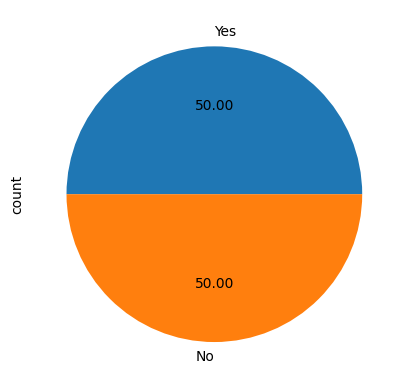

In [34]:
#built-in OverSampling
oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
x_train_res, y_train_res = oversample.fit_resample(x_train, y_train)

resample_plot = y_train_res.value_counts().plot.pie(autopct ='%.2f')
print(y_train_res.value_counts())

In [35]:
#built-in OverSampling
oversample = RandomOverSampler(sampling_strategy='auto', random_state=42)
x_train_res, y_train_res = oversample.fit_resample(x_train, y_train)

params = {
    "n_estimators" : [100,200,300],
    "criterion" : ["gini", "entropy"],
    "class_weight" : [None, "balanced"]
}

preprocessor = ColumnTransformer(transformers= [
    ("num_feature", num_transformer, ["tenure","MonthlyCharges","TotalCharges"]),
    ("ord_feature", ord_transformer, ["gender", "Partner", "Dependents", "PhoneService","MultipleLines" , "InternetService", "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract", "PaperlessBilling"]),
    ("nom_feature", nom_transformer, ["SeniorCitizen","PaymentMethod"]),                             
])

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=100), param_grid=params, cv=4 , verbose=2)

reg = ImbPipeline(steps=[
    ("preporcessor", preprocessor),
    # tham so cua mo hinh và bộ này gọi là siêu tham số do dev chỉ ra để tối ưu mô hình
    ("model", grid_search)
])

reg.fit(x_train_res, y_train_res)
print(grid_search.best_estimator_)
print(grid_search.best_score_)  #score dua tren loss trung binh cua cross validation
print(grid_search.best_params_)

y_predict = reg.predict(x_test)
print(classification_report(y_test, y_predict))


Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] END class_weight=None, criterion=gini, n_estimators=100; total time=   0.4s
[CV] END class_weight=None, criterion=gini, n_estimators=100; total time=   0.4s
[CV] END class_weight=None, criterion=gini, n_estimators=100; total time=   0.4s
[CV] END class_weight=None, criterion=gini, n_estimators=100; total time=   0.4s
[CV] END class_weight=None, criterion=gini, n_estimators=200; total time=   0.8s
[CV] END class_weight=None, criterion=gini, n_estimators=200; total time=   0.8s
[CV] END class_weight=None, criterion=gini, n_estimators=200; total time=   0.8s
[CV] END class_weight=None, criterion=gini, n_estimators=200; total time=   0.8s
[CV] END class_weight=None, criterion=gini, n_estimators=300; total time=   1.4s
[CV] END class_weight=None, criterion=gini, n_estimators=300; total time=   1.4s
[CV] END class_weight=None, criterion=gini, n_estimators=300; total time=   1.4s
[CV] END class_weight=None, criterion=gini, n_es

In [36]:
# Apply OverSampling with LogisticRegression
preprocessor = ColumnTransformer(transformers= [
    ("num_feature", num_transformer, ["tenure","MonthlyCharges","TotalCharges"]),
    ("ord_feature", ord_transformer, ["gender", "Partner", "Dependents", "PhoneService","MultipleLines" , "InternetService", "OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract", "PaperlessBilling"]),
    ("nom_feature", nom_transformer, ["SeniorCitizen","PaymentMethod"]),                             
])

reg = ImbPipeline(steps=[
    ("preporcessor", preprocessor),
    # tham so cua mo hinh và bộ này gọi là siêu tham số do dev chỉ ra để tối ưu mô hình
    ("model", LogisticRegression())
])

reg.fit(x_train_res, y_train_res)
print(grid_search.best_estimator_)
print(grid_search.best_score_)      #score dua tren loss trung binh cua cross validation
print(grid_search.best_params_)

y_predict = reg.predict(x_test)
print(classification_report(y_test, y_predict))

RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=100)
0.8973904639175257
{'class_weight': None, 'criterion': 'entropy', 'n_estimators': 300}
              precision    recall  f1-score   support

          No       0.92      0.73      0.81      1035
         Yes       0.52      0.82      0.64       374

    accuracy                           0.75      1409
   macro avg       0.72      0.77      0.73      1409
weighted avg       0.81      0.75      0.77      1409



In [37]:
reg = ImbPipeline(steps=[
    ("preporcessor", preprocessor),
    # tham so cua mo hinh và bộ này gọi là siêu tham số do dev chỉ ra để tối ưu mô hình
    ("model", SVC())
])

reg.fit(x_train_res, y_train_res)
print(grid_search.best_estimator_)
print(grid_search.best_score_)      #score dua tren loss trung binh cua cross validation
print(grid_search.best_params_)

y_predict = reg.predict(x_test)
print(classification_report(y_test, y_predict))

RandomForestClassifier(criterion='entropy', n_estimators=300, random_state=100)
0.8973904639175257
{'class_weight': None, 'criterion': 'entropy', 'n_estimators': 300}
              precision    recall  f1-score   support

          No       0.91      0.73      0.81      1035
         Yes       0.52      0.79      0.63       374

    accuracy                           0.75      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.75      0.76      1409



SMOTE 

In [38]:
# Define the categories for ordinal encoding
gender_values = ['Female', 'Male']
Partner_values = ['No', 'Yes']
Dependents_values = ['No', 'Yes']
PhoneService_values = ['No', 'Yes']
PaperlessBilling_values = ['No', 'Yes']
MultipleLines_values = ['No phone service', 'No', 'Yes']
InternetService_values = ['No', 'DSL', 'Fiber optic']
OnlineSecurity_values = ['No internet service', 'No', 'Yes']
OnlineBackup_values = ['No internet service', 'Yes', 'No']
DeviceProtection_values = ['No internet service', 'No', 'Yes']
TechSupport_values = ['No internet service', 'No', 'Yes']
StreamingTV_values = ['No internet service', 'No', 'Yes']
StreamingMovies_values = ['No internet service', 'No', 'Yes']
Contract_values = ['Month-to-month', 'One year', 'Two year']

# Define the transformers for different column types
numerical_features = ["tenure", "MonthlyCharges", "TotalCharges"]
nominal_features = ["PaymentMethod"]
ordinal_features = [
    "gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService",
    "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV",
    "StreamingMovies", "Contract", "PaperlessBilling"
]

# Create a pipeline for each type of feature
numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

nominal_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OneHotEncoder(sparse_output=False))
])

ordinal_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("encoder", OrdinalEncoder(categories=[
        gender_values, Partner_values, Dependents_values, PhoneService_values, MultipleLines_values,
        InternetService_values, OnlineSecurity_values, OnlineBackup_values, DeviceProtection_values,
        TechSupport_values, StreamingTV_values, StreamingMovies_values, Contract_values, PaperlessBilling_values
    ]))
])

# Combine all pipelines into a single ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_features),
        ("nom", nominal_pipeline, nominal_features),
        ("ord", ordinal_pipeline, ordinal_features)
    ]
)

# Apply transformations to x_train and x_test
x_train_pre = preprocessor.fit_transform(x_train)
x_test_pre = preprocessor.transform(x_test)

# Apply SMOTE for balancing the classes
smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = RandomForestClassifier(n_estimators=300, criterion="entropy", random_state=100, verbose=2)
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))

# Print the shape of the resampled training data
print(x_train_res.shape, y_train_res.shape)


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84 of 300
building tree 85 of 300
building tree 86 of 300
building tree 87 of 300
building tree 88 of 300
building tree 89 of 300
building tree 90

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.3s


building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300
building tree 203 of 300
building tree 204 of 300
building tree 205 of 300
building tree 206 of 300
building tree 207 of 300
building tree 208 of 300
building tree 209 of 300
building tree 210 of 300
building tree 211 of 300
building tree 212 of 300
building tree 213 of 300


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


In [39]:
# Apply SMOTE for balancing the classes
smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = LogisticRegression()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))

# Print the shape of the resampled training data
print(x_train_res.shape, y_train_res.shape)


              precision    recall  f1-score   support

          No       0.91      0.73      0.81      1035
         Yes       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409

(6208, 21) (6208,)


In [40]:
# Apply SMOTE for balancing the classes
smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = SVC()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))

# Print the shape of the resampled training data
print(x_train_res.shape, y_train_res.shape)


              precision    recall  f1-score   support

          No       0.90      0.74      0.81      1035
         Yes       0.52      0.77      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.75      0.76      1409

(6208, 21) (6208,)


ADASYN

In [61]:
# Apply ADASYN for balancing the classes
adasyn = ADASYN(random_state=42)
x_train_res, y_train_res = adasyn.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = RandomForestClassifier(n_estimators=300, criterion="entropy", random_state=100, verbose=2)
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))

# Print the shape of the resampled training data
print(x_train_res.shape, y_train_res.shape)


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84 of 300
building tree 85 of 300
building tree 86 of 300
building tree 87 of 300
building tree 88 of 300
building tree 89 of 300
building tree 90 of 300
building tree 91 of 300
building tree 92 of 300
building tree 93

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.3s


building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300
building tree 203 of 300
building tree 204 of 300
building tree 205 of 300
building tree 206 of 300
building tree 207 of 300
building tree 208 of 300
building tree 209 of 300
building tree 210 of 300
building tree 211 of 300
building tree 212 of 300
building tree 213 of 300
building tree 214 of 300
building tree 215 of 300


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


In [60]:
# Apply ADASYN for balancing the classes
adasyn = ADASYN(random_state=42)
x_train_res, y_train_res = adasyn.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = LogisticRegression()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))

# Print the shape of the resampled training data
print(x_train_res.shape, y_train_res.shape)


              precision    recall  f1-score   support

          No       0.93      0.67      0.78      1035
         Yes       0.49      0.87      0.62       374

    accuracy                           0.72      1409
   macro avg       0.71      0.77      0.70      1409
weighted avg       0.81      0.72      0.74      1409

(6165, 21) (6165,)


In [59]:
# Apply ADASYN for balancing the classes
adasyn = ADASYN(random_state=42)
x_train_res, y_train_res = adasyn.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = SVC()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))



              precision    recall  f1-score   support

          No       0.93      0.65      0.77      1035
         Yes       0.47      0.86      0.61       374

    accuracy                           0.71      1409
   macro avg       0.70      0.76      0.69      1409
weighted avg       0.81      0.71      0.72      1409



BorderlineSMOTE

In [67]:

bls = BorderlineSMOTE(random_state=42)
x_train_res, y_train_res = bls.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = RandomForestClassifier(n_estimators=300, criterion="entropy", random_state=100, verbose=2)
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))

# Print the shape of the resampled training data
print(x_train_res.shape, y_train_res.shape)


building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84 of 300
building tree 85 of 300
building tree 86 of 300
building tree 87 of 300
building tree 88 of 300
building tree 89 of 300
building tree 90 of 300
building tree 91

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.3s


building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300
building tree 203 of 300
building tree 204 of 300
building tree 205 of 300
building tree 206 of 300
building tree 207 of 300


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


In [65]:
bls = BorderlineSMOTE(random_state=42)

x_train_res, y_train_res = bls.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = LogisticRegression()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

          No       0.94      0.66      0.78      1035
         Yes       0.48      0.88      0.62       374

    accuracy                           0.72      1409
   macro avg       0.71      0.77      0.70      1409
weighted avg       0.82      0.72      0.73      1409



In [66]:
bls = BorderlineSMOTE(random_state=42)

x_train_res, y_train_res = bls.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = SVC()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

          No       0.93      0.64      0.76      1035
         Yes       0.47      0.87      0.61       374

    accuracy                           0.70      1409
   macro avg       0.70      0.76      0.68      1409
weighted avg       0.81      0.70      0.72      1409



SVMSMOTE

In [69]:
svm_smote = SVMSMOTE(random_state=42)
x_train_res, y_train_res = svm_smote.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = RandomForestClassifier(n_estimators=300, criterion="entropy", random_state=100, verbose=2)
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))



building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.3s


building tree 47 of 300
building tree 48 of 300
building tree 49 of 300
building tree 50 of 300
building tree 51 of 300
building tree 52 of 300
building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84 of 300
building tree 85 of 300
building tree 86 of 300
building tree 87 of 300
building tree 88

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.4s


building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300
building tree 203 of 300
building tree 204 of 300
building tree 205 of 300
building tree 206 of 300
building tree 207 of 300
building tree 208 of 300
building tree 209 of 300
building tree 210 of 300
building tree 211 of 300
building tree 212 of 300
building tree 213 of 300
building tree 214 of 300
building tree 215 of 300
building tree 216 of 300
building tree 217 of 300
building tree 218 of 300
building tree 219 of 300
building tree 220 of 300
building tree 221 of 300


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


In [70]:
svm_smote = SVMSMOTE(random_state=42)
x_train_res, y_train_res = svm_smote.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = LogisticRegression()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))



              precision    recall  f1-score   support

          No       0.91      0.72      0.81      1035
         Yes       0.51      0.81      0.63       374

    accuracy                           0.74      1409
   macro avg       0.71      0.77      0.72      1409
weighted avg       0.81      0.74      0.76      1409



In [71]:
svm_smote = SVMSMOTE(random_state=42)
x_train_res, y_train_res = svm_smote.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = SVC()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))



              precision    recall  f1-score   support

          No       0.90      0.73      0.80      1035
         Yes       0.51      0.78      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



KMeansSMOTE

In [73]:
kmean_smote = KMeansSMOTE(random_state=42)
x_train_res, y_train_res = kmean_smote.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = RandomForestClassifier(n_estimators=300, criterion="entropy", random_state=100, verbose=2)
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))



building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84 of 300
building tree 85 of 300
building tree 86 of 300
building tree 87 of 300
building tree 88 of 300
building tree 89 of 300
building tree 90 of 300
building tree 91 of 300
building tree 92 of 300
building tree 93 of 300
building tree 94 of 300
building tree 95

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.2s


building tree 163 of 300
building tree 164 of 300
building tree 165 of 300
building tree 166 of 300
building tree 167 of 300
building tree 168 of 300
building tree 169 of 300
building tree 170 of 300
building tree 171 of 300
building tree 172 of 300
building tree 173 of 300
building tree 174 of 300
building tree 175 of 300
building tree 176 of 300
building tree 177 of 300
building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


In [74]:
kmean_smote = KMeansSMOTE(random_state=42)
x_train_res, y_train_res = kmean_smote.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = LogisticRegression()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))



              precision    recall  f1-score   support

          No       0.87      0.82      0.85      1035
         Yes       0.58      0.67      0.62       374

    accuracy                           0.78      1409
   macro avg       0.72      0.74      0.73      1409
weighted avg       0.79      0.78      0.79      1409



In [75]:
kmean_smote = KMeansSMOTE(random_state=42)
x_train_res, y_train_res = kmean_smote.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = SVC()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))



              precision    recall  f1-score   support

          No       0.84      0.87      0.85      1035
         Yes       0.60      0.53      0.56       374

    accuracy                           0.78      1409
   macro avg       0.72      0.70      0.71      1409
weighted avg       0.77      0.78      0.78      1409



SMOTETomek

In [77]:
smt = SMOTETomek(random_state=42)
x_train_res, y_train_res = smt.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = RandomForestClassifier(n_estimators=300, criterion="entropy", random_state=100, verbose=2)
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))



building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.2s


building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84 of 300
building tree 85 of 300
building tree 86 of 300
building tree 87 of 300
building tree 88 of 300
building tree 89 of 300
building tree 90 of 300
building tree 91 of 300
building tree 92 of 300
building tree 93 of 300
building tree 94 of 300
building tree 95

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    1.2s


building tree 178 of 300
building tree 179 of 300
building tree 180 of 300
building tree 181 of 300
building tree 182 of 300
building tree 183 of 300
building tree 184 of 300
building tree 185 of 300
building tree 186 of 300
building tree 187 of 300
building tree 188 of 300
building tree 189 of 300
building tree 190 of 300
building tree 191 of 300
building tree 192 of 300
building tree 193 of 300
building tree 194 of 300
building tree 195 of 300
building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300
building tree 203 of 300
building tree 204 of 300
building tree 205 of 300
building tree 206 of 300
building tree 207 of 300
building tree 208 of 300
building tree 209 of 300
building tree 210 of 300
building tree 211 of 300
building tree 212 of 300
building tree 213 of 300
building tree 214 of 300
building tree 215 of 300
building tree 216 of 300
building tree 217 of 300


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


In [78]:
smt = SMOTETomek(random_state=42)
x_train_res, y_train_res = smt.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = LogisticRegression()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))



              precision    recall  f1-score   support

          No       0.91      0.73      0.81      1035
         Yes       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



In [79]:
smt = SMOTETomek(random_state=42)
x_train_res, y_train_res = smt.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = SVC()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))



              precision    recall  f1-score   support

          No       0.90      0.74      0.81      1035
         Yes       0.52      0.76      0.62       374

    accuracy                           0.75      1409
   macro avg       0.71      0.75      0.72      1409
weighted avg       0.80      0.75      0.76      1409



SMOTEENN

In [81]:
sme = SMOTEENN(random_state=42)
x_train_res, y_train_res = sme.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = RandomForestClassifier(n_estimators=300, criterion="entropy", random_state=100, verbose=2)
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))



building tree 1 of 300
building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
b

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s


building tree 53 of 300
building tree 54 of 300
building tree 55 of 300
building tree 56 of 300
building tree 57 of 300
building tree 58 of 300
building tree 59 of 300
building tree 60 of 300
building tree 61 of 300
building tree 62 of 300
building tree 63 of 300
building tree 64 of 300
building tree 65 of 300
building tree 66 of 300
building tree 67 of 300
building tree 68 of 300
building tree 69 of 300
building tree 70 of 300
building tree 71 of 300
building tree 72 of 300
building tree 73 of 300
building tree 74 of 300
building tree 75 of 300
building tree 76 of 300
building tree 77 of 300
building tree 78 of 300
building tree 79 of 300
building tree 80 of 300
building tree 81 of 300
building tree 82 of 300
building tree 83 of 300
building tree 84 of 300
building tree 85 of 300
building tree 86 of 300
building tree 87 of 300
building tree 88 of 300
building tree 89 of 300
building tree 90 of 300
building tree 91 of 300
building tree 92 of 300
building tree 93 of 300
building tree 94

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.6s


building tree 196 of 300
building tree 197 of 300
building tree 198 of 300
building tree 199 of 300
building tree 200 of 300
building tree 201 of 300
building tree 202 of 300
building tree 203 of 300
building tree 204 of 300
building tree 205 of 300
building tree 206 of 300
building tree 207 of 300
building tree 208 of 300
building tree 209 of 300
building tree 210 of 300
building tree 211 of 300
building tree 212 of 300
building tree 213 of 300
building tree 214 of 300
building tree 215 of 300
building tree 216 of 300
building tree 217 of 300
building tree 218 of 300
building tree 219 of 300
building tree 220 of 300
building tree 221 of 300
building tree 222 of 300
building tree 223 of 300
building tree 224 of 300
building tree 225 of 300
building tree 226 of 300
building tree 227 of 300
building tree 228 of 300
building tree 229 of 300
building tree 230 of 300
building tree 231 of 300
building tree 232 of 300
building tree 233 of 300
building tree 234 of 300
building tree 235 of 300


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


In [82]:
sme = SMOTEENN(random_state=42)
x_train_res, y_train_res = smt.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = LogisticRegression()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))



              precision    recall  f1-score   support

          No       0.91      0.73      0.81      1035
         Yes       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.76      0.71      1409
weighted avg       0.80      0.74      0.76      1409



In [83]:
sme = SMOTEENN(random_state=42)
x_train_res, y_train_res = sme.fit_resample(x_train_pre, y_train)

# Define and train the RandomForest model
model = SVC()
model.fit(x_train_res, y_train_res)

# Make predictions and evaluate the model
y_predict = model.predict(x_test_pre)
print(classification_report(y_test, y_predict))



              precision    recall  f1-score   support

          No       0.93      0.66      0.77      1035
         Yes       0.48      0.86      0.62       374

    accuracy                           0.71      1409
   macro avg       0.70      0.76      0.69      1409
weighted avg       0.81      0.71      0.73      1409

